# AI vs Human — Text Classification

In [ ]:
# Librerie base
%pip install -q pandas seaborn scikit-learn gensim numpy tensorflow matplotlib

# Download dataset da Kaggle
%pip install -q kagglehub

In [47]:
import os
import re
import kagglehub
# Data analysis & visualizzazione
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt



# NLP
from sklearn.calibration import CalibratedClassifierCV
import gensim
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.manifold import TSNE
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    classification_report,
    roc_curve,
    roc_auc_score
)


# Deep learning
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

## Caricamento datatset e pre-processing

In [3]:
path = kagglehub.dataset_download("shanegerami/ai-vs-human-text")

csv_path = os.path.join(path, "AI_Human.csv")

df_grezzo = pd.read_csv(csv_path)

print("Colonne:", list(df_grezzo.columns))

print("Esempio di dati:")
df_grezzo.head()

Colonne: ['text', 'generated']
Esempio di dati:


,text,generated
0,Cars. Cars have been around since they became ...,0.0
1,Transportation is a large necessity in most co...,0.0
2,"""America's love affair with it's vehicles seem...",0.0
3,How often do you ride in a car? Do you drive a...,0.0
4,Cars are a wonderful thing. They are perhaps o...,0.0


In [5]:
df_grezzo = df_grezzo.rename(columns={"generated": "target"})
df = (
    df_grezzo
    .groupby('target', group_keys=False)
    .sample(n=5000, random_state=42)
    .reset_index(drop=True)
)
df["target"] = df["target"].map({
    0.0: "human",
    1.0: "ai"
}).astype("category")
print(df['target'].value_counts())
df.head()

target
ai       5000
human    5000
Name: count, dtype: int64


,text,target
0,Do curfews keep teenagers from Getting into tr...,human
1,"In this article ""The Challenge of Exploring Ve...",human
2,With THP rapid growth of THP Internet in recen...,human
3,The electoral College is the way Us United Sta...,human
4,This technology of you can calculate the emoti...,human


In [ ]:
# Dimensione del dataset
print(f"Numero di righe: {df.shape[0]}")
print(f"Numero di colonne: {df.shape[1]}")

# Tipi di dati
print("\nTipi di dati:")
print(df.dtypes)

# Valori mancanti
print("\nValori mancanti per colonna:")
print(df.isnull().sum())

Numero di righe: 10000
Numero di colonne: 2

Tipi di dati:
text        object
target    category
dtype: object

Valori mancanti per colonna:
text      0
target    0
dtype: int64

Duplicati: 0
Duplicati solo nel testo: 0


In [11]:
import re
import unicodedata

_url_re = re.compile(r"https?://\S+|www\.\S+")
_mention_re = re.compile(r"@\w+")
_hashtag_re = re.compile(r"#(\w+)")
_email_re = re.compile(r"\b[\w.+-]+@[\w-]+\.[\w.-]+\b")
_multispace_re = re.compile(r"\s+")
_repeat_re = re.compile(r"(.)\1{3,}")   # limita ripetizioni a max 3
_space_punct_re = re.compile(r"\s+([?!.,;:])")  # spazi prima della punteggiatura

def normalize_unicode(s: str) -> str:
    # Normalizza accenti/virgolette “smart”
    s = unicodedata.normalize("NFKC", s)
    return s

def clean_text(text: str) -> str:
    if not isinstance(text, str):
        return ""
    text = normalize_unicode(text)

    # URL / email / menzioni / hashtag
    text = _url_re.sub(" ", text)
    text = _email_re.sub(" EMAIL ", text)
    text = _mention_re.sub(" MENTION ", text)
    text = _hashtag_re.sub(r"\1", text)  # tieni la parola dell’hashtag

    # minuscole
    text = text.lower()

    # limita caratteri ripetuti e sistema spaziatura
    text = _repeat_re.sub(r"\1\1\1", text)
    text = _space_punct_re.sub(r"\1", text)

    # compattazione spazi
    text = _multispace_re.sub(" ", text).strip()
    return text

# Applica pulizia
df["text"] = df["text"].apply(clean_text)

# Rimuovi vuoti
mask_empty = df["text"].str.strip().eq("")
print("Testi vuoti rimossi:", int(mask_empty.sum()))
df = df.loc[~mask_empty].reset_index(drop=True)

# Ricontrollo duplicati di testo dopo pulizia (facoltativo ma utile)
dup_after = df.duplicated(subset=["text"]).sum()
if dup_after > 0:
    print("Duplicati (post-clean) rimossi:", int(dup_after))
    df = df.drop_duplicates(subset=["text"]).reset_index(drop=True)

# Anteprima
display(df.head(3))

Testi vuoti rimossi: 0
Duplicati (post-clean) rimossi: 5


,text,target
0,do curfews keep teenagers from getting into tr...,human
1,"in this article ""the challenge of exploring ve...",human
2,with thp rapid growth of thp internet in recen...,human


## Split Train/Val/Test-Sets

In [12]:
X = df["text"]
y = df["target"]

# 1) train (70%) vs temp (30% = val+test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)

# 2) val (15%) vs test (15%) dalla parte temporanea
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

print("Train:", len(X_train), " Val:", len(X_val), " Test:", len(X_test))


Train: 6996  Val: 1499  Test: 1500


📏 Numero minimo di parole: 20
📏 Numero medio di parole: 381.23
📏 Numero massimo di parole: 1367

📝 Testo con più parole:
fo the state and the state's country, the election of our president must be seen carefully and wisely. as the citizens of the state, people must realize that choosing someone to take control of orders and regulations and the way the country evolves, is a process that needs to be thought of and taken fairly. fhe president is to serve the people of his country well with responsibilities that can vary to meet the needs of the country, but the electoral college seems to become more and more unfair t...


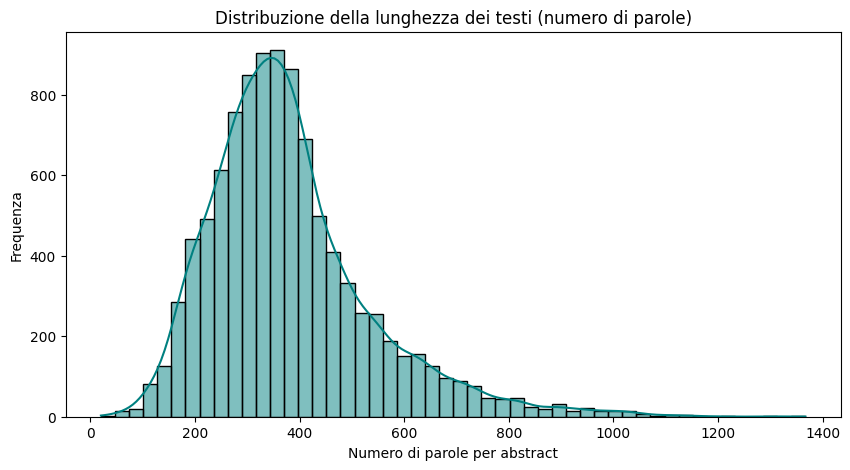

In [ ]:
# Calcolo del numero di parole per ciascun testo
word_counts = df["text"].apply(lambda x: len(str(x).split()))

# Massimo, media, minimo
max_word_count = word_counts.max()
mean_word_count = word_counts.mean()
min_word_count = word_counts.min()

# Ottieni il testo più lungo
max_word_index = word_counts.idxmax()
max_word_text = df.loc[max_word_index, "text"]

print(f"Numero minimo di parole: {min_word_count}")
print(f"Numero medio di parole: {mean_word_count:.2f}")
print(f"Numero massimo di parole: {max_word_count}\n")
print(f"Testo con più parole:\n{max_word_text[:500]}...")  # stampiamo solo i primi 500 caratteri

# Distribuzione grafica delle lunghezze
plt.figure(figsize=(10,5))
sns.histplot(word_counts, bins=50, kde=True, color='teal')
plt.title("Distribuzione della lunghezza dei testi (numero di parole)")
plt.xlabel("Numero di parole per abstract")
plt.ylabel("Frequenza")
plt.show()


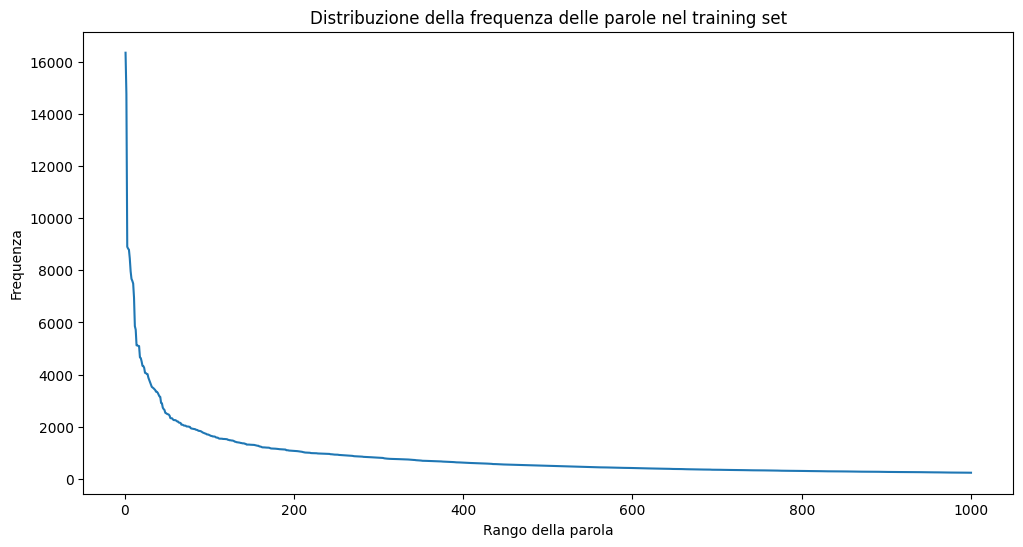

Top 20 parole più frequenti:
students                  16347
people                    14761
like                      8903
car                       8833
school                    8789
electoral                 8457
cars                      7965
help                      7673
time                      7595
college                   7492
make                      6953
just                      5857
states                    5721
think                     5120
vote                      5120
life                      5097
work                      5093
student                   4658
way                       4632
use                       4502


In [15]:
# Calcolo della frequenza delle parole
vectorizer = CountVectorizer(stop_words='english')
X_counts = vectorizer.fit_transform(X_train)  # Usa il nuovo training set

# Ordinare le parole per frequenza
word_freq = dict(zip(vectorizer.get_feature_names_out(), X_counts.sum(axis=0).A1))
sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)

# Plot della distribuzione delle parole più frequenti
top_words = 1000  # Analizza le prime 1000 parole
plt.figure(figsize=(12, 6))
plt.plot(range(1, top_words + 1), [freq for _, freq in sorted_word_freq[:top_words]])
plt.xlabel('Rango della parola')
plt.ylabel('Frequenza')
plt.title('Distribuzione della frequenza delle parole nel training set')
plt.show()

# Mostra le 20 più frequenti
print("Top 20 parole più frequenti:")
for word, freq in sorted_word_freq[:20]:
    print(f"{word:<25} {freq}")


## Classificazione

In [ ]:
# Parametri comuni: unigrammi+bigrammi, limite vocab, filtri df
ngram = (1, 2)
min_df = 5
max_df = 0.90
max_feat = 1000

# TF-IDF (meglio per LR/SVM). 
tfidf = TfidfVectorizer(
    ngram_range=ngram,
    min_df=min_df,
    max_df=max_df,
    max_features=max_feat,
    sublinear_tf=True,
    lowercase=False,
    stop_words=None
)

print("Calcolo TF-IDF ...")
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf   = tfidf.transform(X_val)
X_test_tfidf  = tfidf.transform(X_test)

print("TF-IDF completato.")
print("Train:", X_train_tfidf.shape, " Val:", X_val_tfidf.shape, " Test:", X_test_tfidf.shape)
feature_names_tfidf = tfidf.get_feature_names_out()
print("Esempio feature TF-IDF:", feature_names_tfidf[:20])


Calcolo TF-IDF ...
TF-IDF completato.
Train: (6996, 1000)  Val: (1499, 1000)  Test: (1500, 1000)
Esempio feature TF-IDF: ['ability' 'ability to' 'able' 'able to' 'about' 'about the' 'academic'
 'access' 'accidents' 'according' 'according to' 'achieve' 'action'
 'action coding' 'activities' 'activity' 'actually' 'addition'
 'additionally' 'advantage']


### Naive Bayes

In [30]:
# Addestramento del modello Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)  # Usa il nuovo training set

# Valutazione sul validation set
y_pred_val_nb = nb_model.predict(X_val_tfidf)

# Report delle metriche
print("Naive Bayes Validation Accuracy:", accuracy_score(y_val, y_pred_val_nb))
print("Classification Report sul Validation Set:\n", classification_report(y_val, y_pred_val_nb))

Naive Bayes Validation Accuracy: 0.9106070713809206
Classification Report sul Validation Set:
               precision    recall  f1-score   support

          ai       0.97      0.85      0.90       750
       human       0.86      0.97      0.92       749

    accuracy                           0.91      1499
   macro avg       0.92      0.91      0.91      1499
weighted avg       0.92      0.91      0.91      1499



#### Test - Naive Bayes

Naive Bayes Test Accuracy: 0.9166666666666666
Test Set Classification Report:
               precision    recall  f1-score   support

          ai       0.97      0.86      0.91       750
       human       0.87      0.97      0.92       750

    accuracy                           0.92      1500
   macro avg       0.92      0.92      0.92      1500
weighted avg       0.92      0.92      0.92      1500



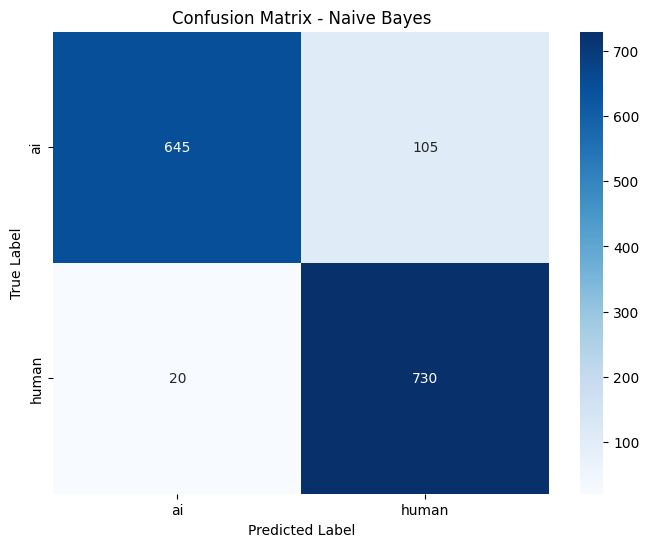

In [31]:
# Valutazione sul test set
y_pred_test = nb_model.predict(X_test_tfidf)

# Calcolo della accuracy
test_accuracy = accuracy_score(y_test, y_pred_test)
print("Naive Bayes Test Accuracy:", test_accuracy)

# Report dettagliato di classificazione
print("Test Set Classification Report:\n", classification_report(y_test, y_pred_test))

# Calcolo della matrice di confusione
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Visualizzazione con Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=nb_model.classes_, yticklabels=nb_model.classes_)
plt.title("Confusion Matrix - Naive Bayes")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


AUC (classe positiva = 'ai'): 0.9707


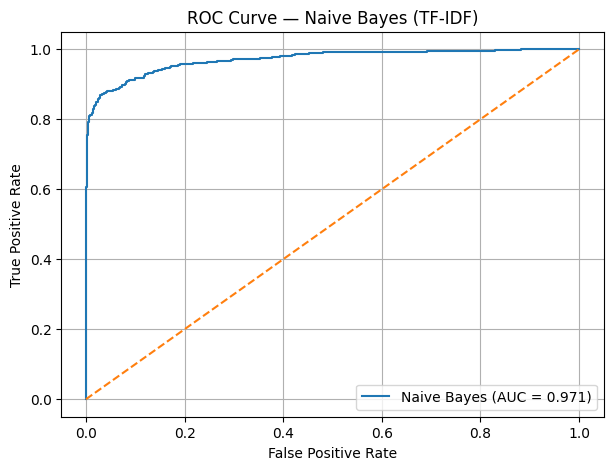

In [32]:
# Cella — ROC/AUC per Naive Bayes (binaria)
# Scegli la classe positiva (qui: "ai")
pos_label = "ai"

# Probabilità stimate
proba_test = nb_model.predict_proba(X_test_tfidf)

# Indice della classe positiva nell'array di probabilità
classes = nb_model.classes_
pos_idx = np.where(classes == pos_label)[0][0]

# y_true binaria e y_score (probabilità della classe positiva)
y_true = (np.asarray(y_test) == pos_label).astype(int)
y_score = proba_test[:, pos_idx]

# Curva ROC e AUC
fpr, tpr, _ = roc_curve(y_true, y_score)
auc = roc_auc_score(y_true, y_score)
print(f"AUC (classe positiva = '{pos_label}'): {auc:.4f}")

# Plot
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f"Naive Bayes (AUC = {auc:.3f})")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Naive Bayes (TF-IDF)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


## Logistic Regression

In [33]:
# Addestramento del modello Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_tfidf, y_train)  # Usa il nuovo training set

# Valutazione sul validation set
y_pred_val_lr = lr_model.predict(X_val_tfidf)

# Report delle metriche
print("Logistic Regression Validation Accuracy:", accuracy_score(y_val, y_pred_val_lr))
print("Classification Report sul Validation Set:\n", classification_report(y_val, y_pred_val_lr))

Logistic Regression Validation Accuracy: 0.9833222148098733
Classification Report sul Validation Set:
               precision    recall  f1-score   support

          ai       1.00      0.97      0.98       750
       human       0.97      1.00      0.98       749

    accuracy                           0.98      1499
   macro avg       0.98      0.98      0.98      1499
weighted avg       0.98      0.98      0.98      1499



#### Test and Results - Logistic Regression

Logistic Regression Test Accuracy: 0.98
Test Set Classification Report:
               precision    recall  f1-score   support

          ai       0.99      0.97      0.98       750
       human       0.97      0.99      0.98       750

    accuracy                           0.98      1500
   macro avg       0.98      0.98      0.98      1500
weighted avg       0.98      0.98      0.98      1500



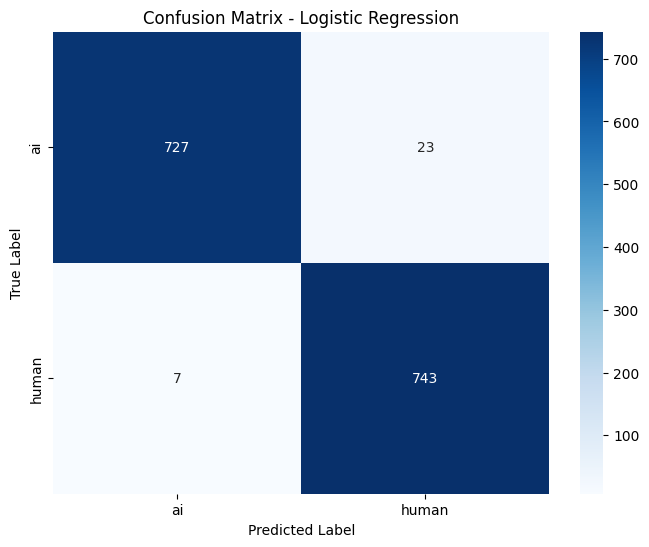

In [34]:
# Valutazione sul test set
y_pred_test_lr = lr_model.predict(X_test_tfidf)

# Calcolo della accuracy
test_accuracy_lr = accuracy_score(y_test, y_pred_test_lr)
print("Logistic Regression Test Accuracy:", test_accuracy_lr)

# Report dettagliato di classificazione
print("Test Set Classification Report:\n", classification_report(y_test, y_pred_test_lr))

# Calcolo della matrice di confusione
conf_matrix_lr = confusion_matrix(y_test, y_pred_test_lr)

# Visualizzazione con Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lr, annot=True, fmt="d", cmap="Blues", xticklabels=lr_model.classes_, yticklabels=lr_model.classes_)
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

AUC LR (pos='ai'): 0.9964


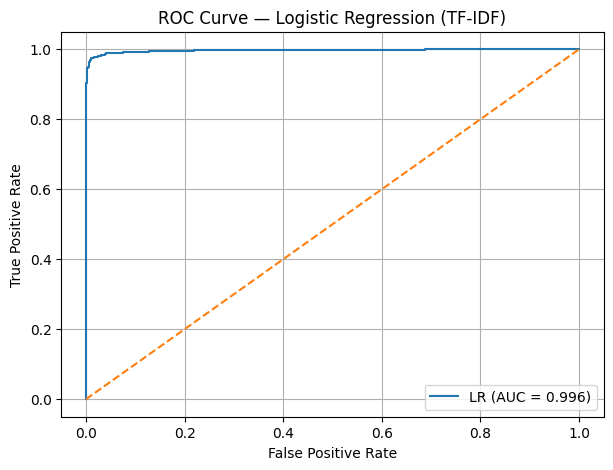

In [35]:
pos_label = "ai"

# Probabilità classe positiva
proba_test_lr = lr_model.predict_proba(X_test_tfidf)
classes_lr = lr_model.classes_
pos_idx = np.where(classes_lr == pos_label)[0][0]

y_true = (np.asarray(y_test) == pos_label).astype(int)
y_score = proba_test_lr[:, pos_idx]

fpr, tpr, _ = roc_curve(y_true, y_score)
auc = roc_auc_score(y_true, y_score)
print(f"AUC LR (pos='{pos_label}'): {auc:.4f}")

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f"LR (AUC = {auc:.3f})")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Logistic Regression (TF-IDF)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


## Support Vector Machine (SVM)

In [36]:
# Addestramento del modello SVM
svm_model = LinearSVC(max_iter=1000, random_state=42)
svm_model.fit(X_train_tfidf, y_train)  # Usa il nuovo training set

# Valutazione sul validation set
y_pred_val_svm = svm_model.predict(X_val_tfidf)

# Report delle metriche
print("SVM Validation Accuracy:", accuracy_score(y_val, y_pred_val_svm))
print("Classification Report sul Validation Set:\n", classification_report(y_val, y_pred_val_svm))

SVM Validation Accuracy: 0.9906604402935291
Classification Report sul Validation Set:
               precision    recall  f1-score   support

          ai       1.00      0.99      0.99       750
       human       0.99      1.00      0.99       749

    accuracy                           0.99      1499
   macro avg       0.99      0.99      0.99      1499
weighted avg       0.99      0.99      0.99      1499



Linear SVM Test Accuracy: 0.9866666666666667
Test Set Classification Report:
               precision    recall  f1-score   support

          ai       0.99      0.98      0.99       750
       human       0.98      0.99      0.99       750

    accuracy                           0.99      1500
   macro avg       0.99      0.99      0.99      1500
weighted avg       0.99      0.99      0.99      1500



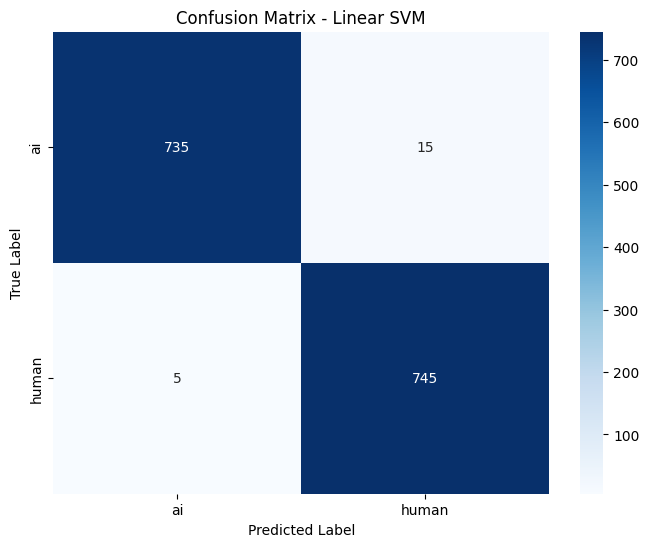

In [37]:
# Valutazione sul test set
y_pred_test_svm = svm_model.predict(X_test_tfidf)

# Calcolo della accuracy
test_accuracy_svm = accuracy_score(y_test, y_pred_test_svm)
print("Linear SVM Test Accuracy:", test_accuracy_svm)

# Report dettagliato di classificazione
print("Test Set Classification Report:\n", classification_report(y_test, y_pred_test_svm))

# Calcolo della matrice di confusione
conf_matrix_svm = confusion_matrix(y_test, y_pred_test_svm)

# Visualizzazione con Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svm, annot=True, fmt="d", cmap="Blues", xticklabels=svm_model.classes_, yticklabels=svm_model.classes_)
plt.title("Confusion Matrix - Linear SVM")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

AUC SVM (pos='ai'): 0.9979


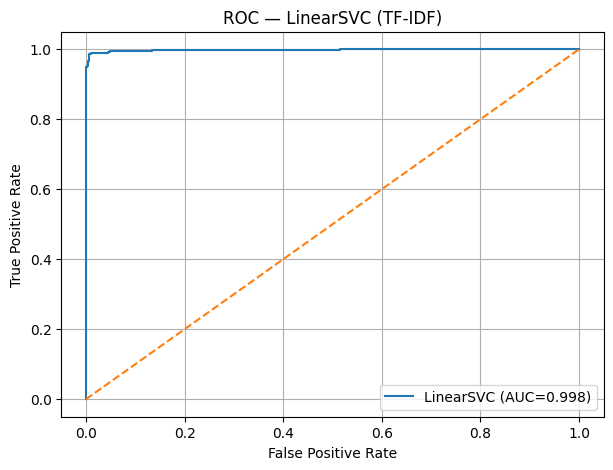

In [38]:
pos_label = "ai"  # classe positiva

# Distanza dal margine: score continuo per la ROC
scores = svm_model.decision_function(X_test_tfidf)  # shape: (n_samples,)

# Attenzione: per LinearSVC binaria, lo score è positivo per classes_[1]
classes = svm_model.classes_
if classes[1] == pos_label:
    y_score = scores
else:
    # se la tua classe positiva non è classes_[1], inverti il segno
    y_score = -scores

y_true = (np.asarray(y_test) == pos_label).astype(int)

# Curva ROC e AUC
fpr, tpr, _ = roc_curve(y_true, y_score)
auc = roc_auc_score(y_true, y_score)
print(f"AUC SVM (pos='{pos_label}'): {auc:.4f}")

# Plot
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f"LinearSVC (AUC={auc:.3f})")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC — LinearSVC (TF-IDF)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


## Rete Neurale (Sequential)

In [ ]:
# Riproducibilità
np.random.seed(42)
tf.random.set_seed(42)

# 1) Label binarie 0/1 (niente one-hot)
le = LabelEncoder()
y_train_bin = le.fit_transform(y_train)  # 0/1
y_val_bin   = le.transform(y_val)
y_test_bin  = le.transform(y_test)

# 2) Converte TF-IDF (sparse) in denso: con 1000 feature 
X_train_dense = X_train_tfidf.toarray().astype("float32")
X_val_dense   = X_val_tfidf.toarray().astype("float32")
X_test_dense  = X_test_tfidf.toarray().astype("float32")

n_features = X_train_dense.shape[1]
print("Input features:", n_features)

# 3) Modello sequenziale
model = Sequential([
    Input(shape=(n_features,)),
    Dense(256, activation="relu"),
    Dropout(0.5),
    Dense(64, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")  # binaria
])

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

model.summary()

# 4) Early stopping su AUC di validazione
es = EarlyStopping(monitor="val_auc", mode="max", patience=3, restore_best_weights=True)

# 5) Train
history = model.fit(
    X_train_dense, y_train_bin,
    validation_data=(X_val_dense, y_val_bin),
    epochs=30,
    batch_size=64,
    callbacks=[es],
    verbose=1
)

# 6) Test
test_loss, test_acc, test_auc = model.evaluate(X_test_dense, y_test_bin, verbose=0)
print(f"Test — Loss: {test_loss:.4f}  Acc: {test_acc:.4f}  AUC: {test_auc:.4f}")


Input features: 1000


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       256,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 272,769 (1.04 MB)

 Trainable params: 272,769 (1.04 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9065 - auc: 0.9669 - loss: 0.2851 - val_accuracy: 0.9726 - val_auc: 0.9959 - val_loss: 0.0750
Epoch 2/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9813 - auc: 0.9961 - loss: 0.0660 - val_accuracy: 0.9840 - val_auc: 0.9977 - val_loss: 0.0488
Epoch 3/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9874 - auc: 0.9977 - loss: 0.0439 - val_accuracy: 0.9873 - val_auc: 0.9983 - val_loss: 0.0399
Epoch 4/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9909 - auc: 0.9986 - loss: 0.0337 - val_accuracy: 0.9913 - val_auc: 0.9985 - val_loss: 0.0337
Epoch 5/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9949 - auc: 0.9991 - loss: 0.0207 - val_accuracy: 0.9920 - val_auc: 0.9986 - val_loss: 0.0330
Epoch 6/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9961 - auc: 0.9996 - loss: 0.0147 - val_accuracy: 0.9873 - val_auc: 0.9987 - val_loss: 0.0378
Epoch 7/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 

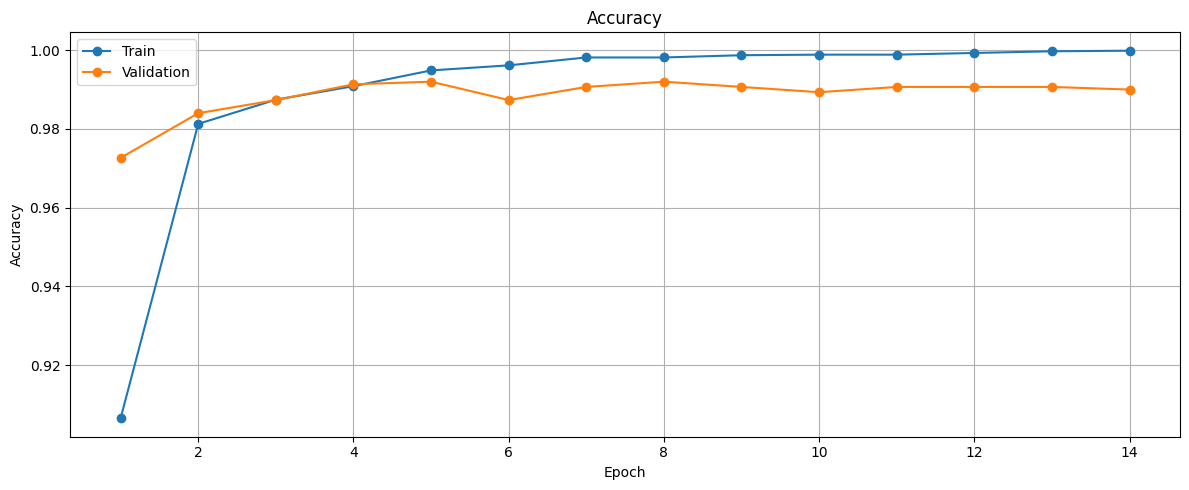

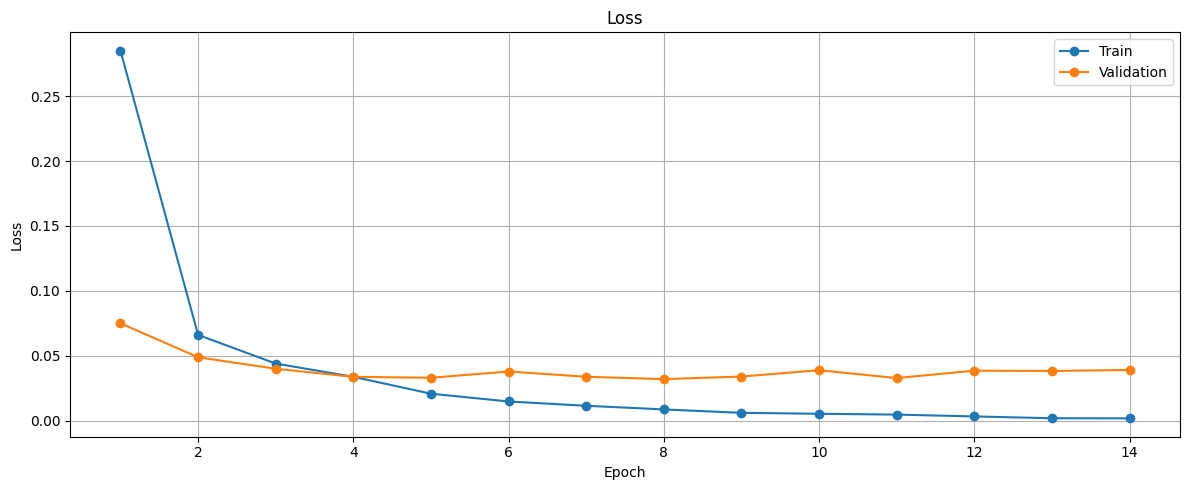

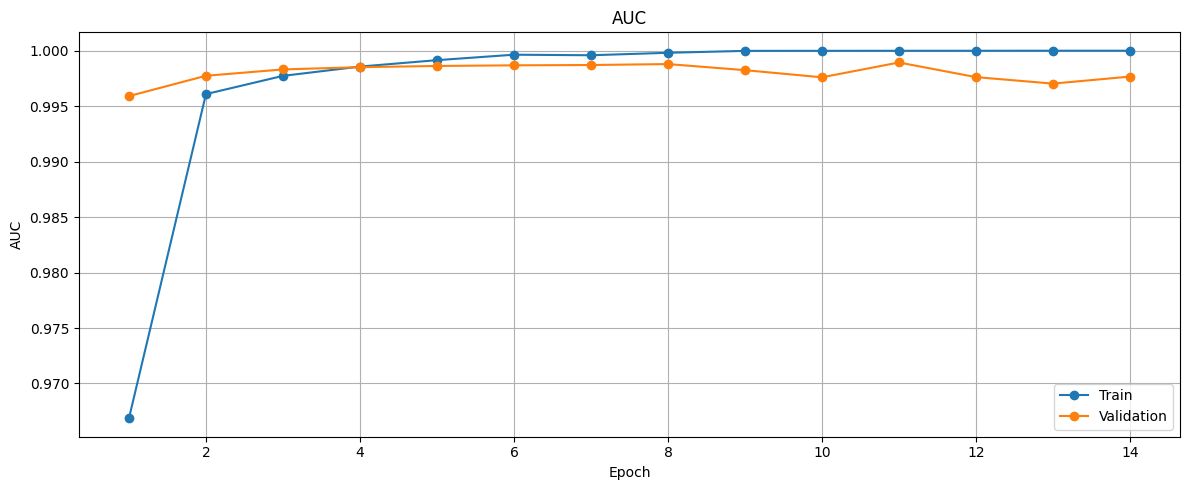

In [43]:
# Cella — Curve di apprendimento (Accuracy, Loss, AUC)

train_acc = history.history.get('accuracy', [])
val_acc   = history.history.get('val_accuracy', [])
train_loss = history.history.get('loss', [])
val_loss   = history.history.get('val_loss', [])
train_auc  = history.history.get('auc', [])
val_auc    = history.history.get('val_auc', [])

epochs = range(1, len(train_acc) + 1)

# Accuracy
plt.figure(figsize=(12, 5))
plt.plot(epochs, train_acc, '-o', label='Train')
plt.plot(epochs, val_acc,  '-o', label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.grid(True); plt.legend(); plt.tight_layout()

# Loss
plt.figure(figsize=(12, 5))
plt.plot(epochs, train_loss, '-o', label='Train')
plt.plot(epochs, val_loss,  '-o', label='Validation')
plt.title('Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.grid(True); plt.legend(); plt.tight_layout()

# AUC (se presente)
if train_auc and val_auc:
    plt.figure(figsize=(12, 5))
    plt.plot(epochs, train_auc, '-o', label='Train')
    plt.plot(epochs, val_auc,  '-o', label='Validation')
    plt.title('AUC')
    plt.xlabel('Epoch'); plt.ylabel('AUC')
    plt.grid(True); plt.legend(); plt.tight_layout()

plt.show()


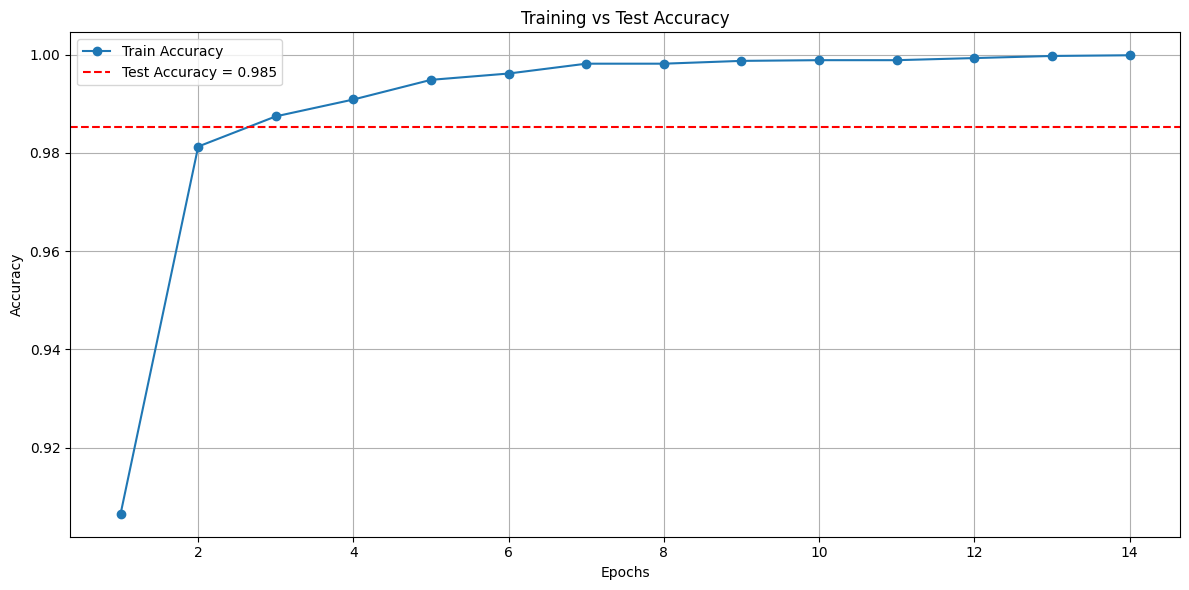

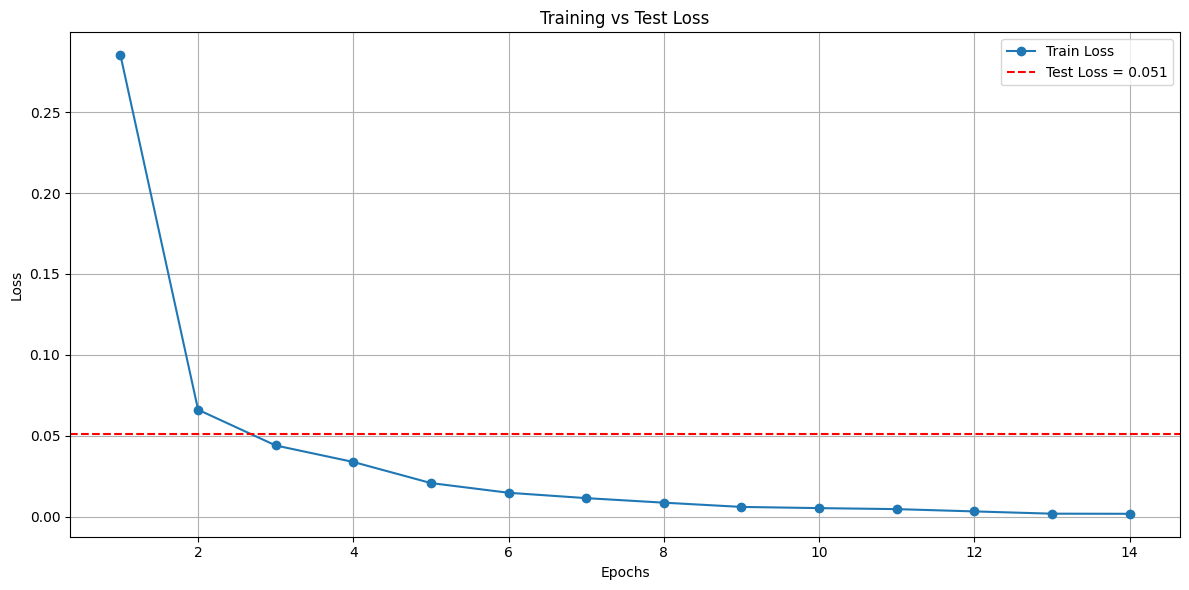

In [45]:
# Cella — Curve con Test come linea orizzontale

# Metriche registrate durante il training
train_accuracy = history.history['accuracy']
train_loss     = history.history['loss']

# Valutazione sul Test
test_loss, test_accuracy, test_auc = model.evaluate(X_test_dense, y_test_bin, verbose=0)

epochs = range(1, len(train_accuracy) + 1)

# Plot Accuracy
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_accuracy, label='Train Accuracy', marker='o')
plt.axhline(y=test_accuracy, color='red', linestyle='--', label=f'Test Accuracy = {test_accuracy:.3f}')
plt.title('Training vs Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Loss
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.axhline(y=test_loss, color='red', linestyle='--', label=f'Test Loss = {test_loss:.3f}')
plt.title('Training vs Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Rete Neurale - LSTM con Word2Vec

In [46]:
# 1) Parametri
emb_dim   = 300
max_vocab = 30000
max_len   = 400   # ~ media 380 parole -> 400 è sensato

# 2) Tokenizzazione semplice (testo già pulito)
def to_tokens(series):
    return [s.split() for s in series]

X_train_tokens = to_tokens(X_train)
X_val_tokens   = to_tokens(X_val)
X_test_tokens  = to_tokens(X_test)

# 3) Addestra Word2Vec SOLO sul train
w2v = Word2Vec(
    sentences=X_train_tokens,
    vector_size=emb_dim,
    window=5,
    min_count=2,
    workers=4,
    sg=1,              # skip-gram
    epochs=10
)
w2v_kv = w2v.wv

# 4) Tokenizer Keras per sequenze (coerente con vocabolario)
tok = Tokenizer(num_words=max_vocab, oov_token="<OOV>")
tok.fit_on_texts(X_train)  # usa stringhe originali (coerente)

# 5) Sequenze + padding
X_train_seq = tok.texts_to_sequences(X_train)
X_val_seq   = tok.texts_to_sequences(X_val)
X_test_seq  = tok.texts_to_sequences(X_test)

X_train_seq = pad_sequences(X_train_seq, maxlen=max_len, padding="post", truncating="post")
X_val_seq   = pad_sequences(X_val_seq,   maxlen=max_len, padding="post", truncating="post")
X_test_seq  = pad_sequences(X_test_seq,  maxlen=max_len, padding="post", truncating="post")

print("Shapes seq:", X_train_seq.shape, X_val_seq.shape, X_test_seq.shape)

# 6) Embedding matrix da Word2Vec (solo per parole nei top max_vocab)
word_index = tok.word_index
vocab_size = min(max_vocab, len(word_index) + 1)
embedding_matrix = np.zeros((vocab_size, emb_dim), dtype="float32")

hits = 0
miss = 0
for word, idx in word_index.items():
    if idx >= vocab_size:
        continue
    if word in w2v_kv:
        embedding_matrix[idx] = w2v_kv[word]
        hits += 1
    else:
        # lascialo a zero (o random piccolo, opzionale)
        miss += 1

print(f"Embedding init: hits={hits}, miss={miss}, vocab_size={vocab_size}, emb_dim={emb_dim}")


Shapes seq: (6996, 400) (1499, 400) (1500, 400)
Embedding init: hits=17280, miss=12719, vocab_size=30000, emb_dim=300


c:\Users\lory8\OneDrive\Desktop\UNIVPM\Data Science\Progetti\NLP 2\.venv\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     9,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,000,000 (34.33 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,000,000 (34.33 MB)

Epoch 1/12
110/110 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.7200 - auc: 0.8002 - loss: 0.5371 - val_accuracy: 0.6925 - val_auc: 0.8512 - val_loss: 0.5251
Epoch 2/12
110/110 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.8090 - auc: 0.8845 - loss: 0.4234 - val_accuracy: 0.8232 - val_auc: 0.9228 - val_loss: 0.3815
Epoch 3/12
110/110 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.8937 - auc: 0.9414 - loss: 0.2879 - val_accuracy: 0.9019 - val_auc: 0.9668 - val_loss: 0.2733
Epoch 4/12
110/110 ━━━━━━━━━━━━━━━━━━━━ 206s 2s/step - accuracy: 0.8822 - auc: 0.9371 - loss: 0.3039 - val_accuracy: 0.9079 - val_auc: 0.9657 - val_loss: 0.2379
Epoch 5/12
110/110 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - accuracy: 0.9274 - auc: 0.9669 - loss: 0.2150 - val_accuracy: 0.9340 - val_auc: 0.9822 - val_loss: 0.2267
Epoch 6/12
110/110 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - accuracy: 0.9411 - auc: 0.9678 - loss: 0.1974 - val_accuracy: 0.9446 - val_auc: 0.9803 - val_loss: 0.1660
Epoch 7/12
110/110 ━━━━━━━━━━━━━━━

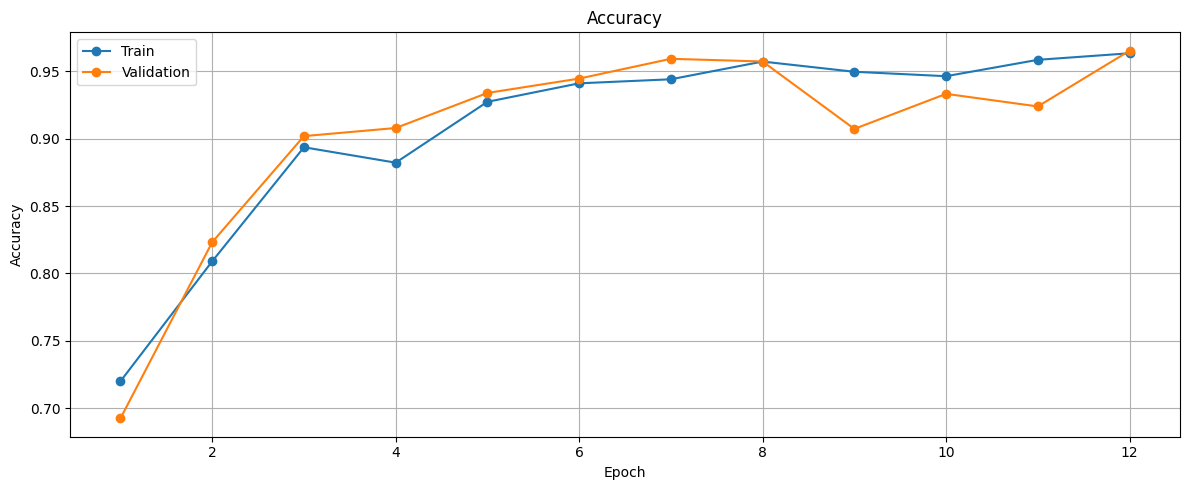

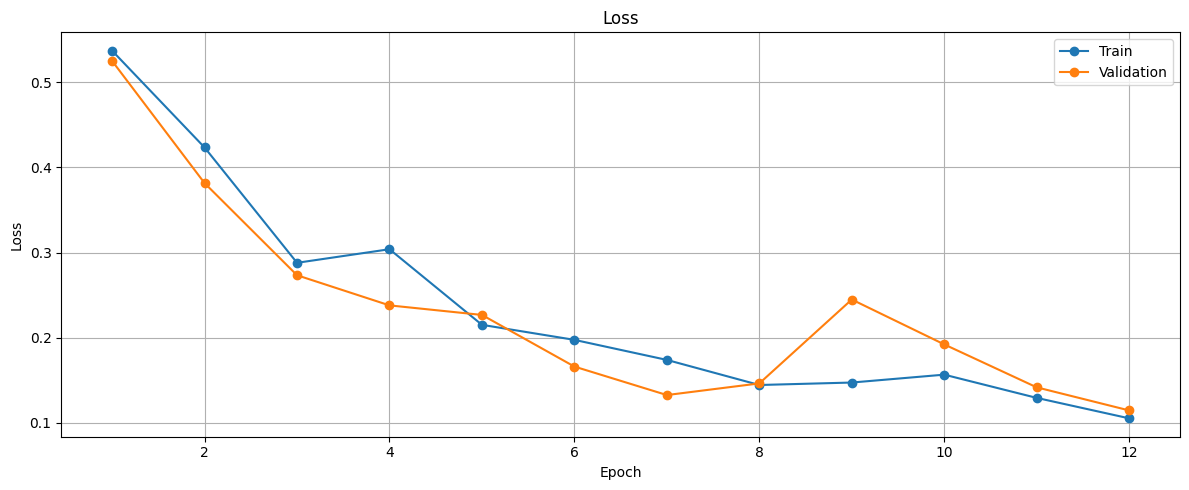

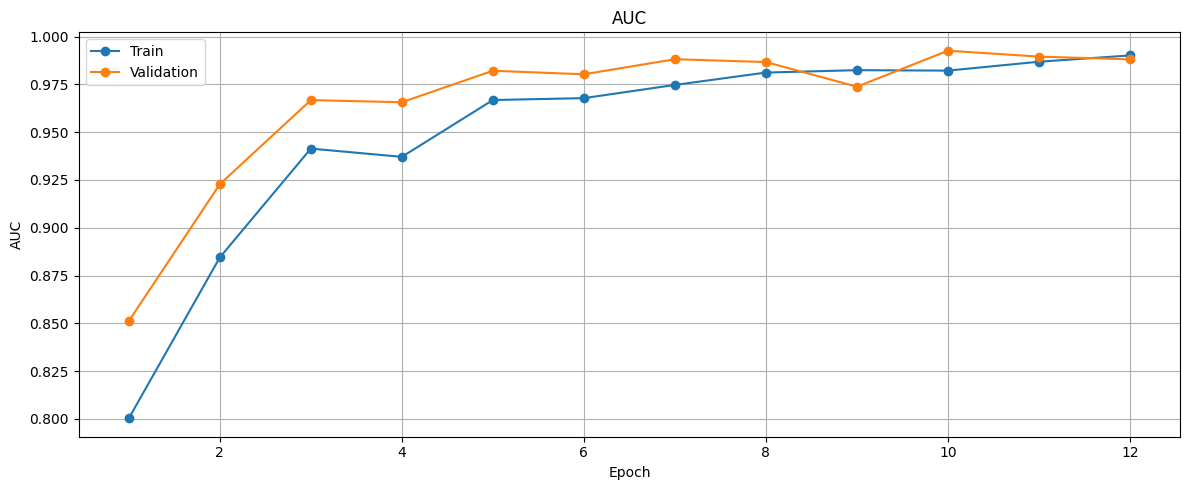

AUC (ROC) — BiLSTM: 0.9928


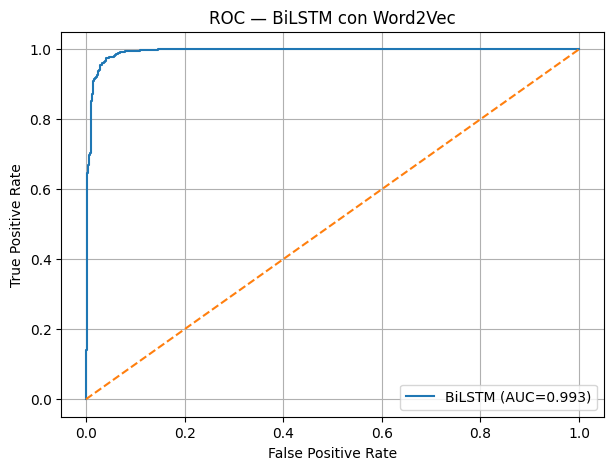

In [ ]:
# 1) Label binarie 0/1 (no one-hot)
le = LabelEncoder()
y_train_bin = le.fit_transform(y_train)
y_val_bin   = le.transform(y_val)
y_test_bin  = le.transform(y_test)

# 2) Modello BiLSTM con pesi Word2Vec
model = Sequential([
    Embedding(
        input_dim=embedding_matrix.shape[0],
        output_dim=embedding_matrix.shape[1],
        input_length=X_train_seq.shape[1],
        weights=[embedding_matrix],
        trainable=False 
    ),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.5),
    LSTM(64),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

model.summary()

# 3) Early stopping su AUC di validazione
es = EarlyStopping(monitor="val_auc", mode="max", patience=3, restore_best_weights=True)

# 4) Train
history = model.fit(
    X_train_seq, y_train_bin,
    validation_data=(X_val_seq, y_val_bin),
    epochs=12,
    batch_size=64,
    callbacks=[es],
    verbose=1
)

# 5) Test
test_loss, test_acc, test_auc = model.evaluate(X_test_seq, y_test_bin, verbose=0)
print(f"Test — Loss: {test_loss:.4f}  Acc: {test_acc:.4f}  AUC: {test_auc:.4f}")

# 6) Curve (Accuracy/Loss/AUC)
epochs = range(1, len(history.history["accuracy"]) + 1)

plt.figure(figsize=(12,5))
plt.plot(epochs, history.history["accuracy"], "-o", label="Train")
plt.plot(epochs, history.history["val_accuracy"], "-o", label="Validation")
plt.title("Accuracy"); plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

plt.figure(figsize=(12,5))
plt.plot(epochs, history.history["loss"], "-o", label="Train")
plt.plot(epochs, history.history["val_loss"], "-o", label="Validation")
plt.title("Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

plt.figure(figsize=(12,5))
plt.plot(epochs, history.history["auc"], "-o", label="Train")
plt.plot(epochs, history.history["val_auc"], "-o", label="Validation")
plt.title("AUC"); plt.xlabel("Epoch"); plt.ylabel("AUC")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# 7) ROC su test
y_score = model.predict(X_test_seq, verbose=0).ravel()
fpr, tpr, _ = roc_curve(y_test_bin, y_score)
auc = roc_auc_score(y_test_bin, y_score)
print(f"AUC (ROC) — BiLSTM: {auc:.4f}")

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f"BiLSTM (AUC={auc:.3f})")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC — BiLSTM con Word2Vec")
plt.legend(loc="lower right"); plt.grid(True); plt.show()
